
# Assignment-7: Apply Support Vector Machine On Amazon Fine Food Reviews DataSet 

## Introduction 

(i).“Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However,  it is mostly used in classification problems.

(ii).The main goal of this algorithm is to find the optimal hyperplane.

## Objective

To Predict the Polarity of Amazon Fine Food Review Using Support Vector Machine Algorithm.

## Importing All Required Library

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV


from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors


import pickle

from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Importing Amazon Fine Food Review  Dataset

In [2]:
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Reviews where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [3]:
# Printing some data of DataFrame

Data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

## Information About DataSet

In [4]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ", Data.shape)
print("\nColumn Name of DataSet : ",Data.columns)
print("\n\nNumber of Attributes/Columns in data: 12") 
print("\nNumber of Positive Reviews : ", Data['Score'].value_counts()[1])
print("\nNumber of Negative Reviews : ", Data['Score'].value_counts()[0])


Number of Reviews:  364171

Number of Users:  243414

Number of Products:  65442

Shape of Data:  (364171, 12)

Column Name of DataSet :  Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')


Number of Attributes/Columns in data: 12

Number of Positive Reviews :  307061

Number of Negative Reviews :  57110


In [5]:
print("\nNumber of Reviews: ",Data["Text"].count())


Number of Reviews:  364171


## Attribute Information About DataSet

1.Id - A unique value starts from 1



2.ProductId - A unique identifier for the product



3.UserId - A unqiue identifier for the user



4.ProfileName - Name of user profile 



5.HelpfulnessNumerator - Number of users who found the review helpful



6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not



7.Score - Rating 0 or 1



8.Time - Timestamp for the review



9.Summary - Brief summary of the review



10.Text - Text of the review



11.Cleaned Text - Text that only alphabets

In [6]:
# Sorting on the basis of Time Parameter
Data.sort_values('Time',inplace=True)

In [7]:
Data=Data.head(100000)

In [8]:
Y = Data['Score']
X = Data['CleanedText']

## Splitting DataSet into Train and Test Data

In [9]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is random splitting

print("Shape of Train and Test Dataset for 100k points")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

Shape of Train and Test Dataset for 100k points
(67000,) (67000,)
(33000,) (33000,)


## Defining Some Function

###  Train Data Confusion Matrix Plot

In [10]:
def trainconfusionmatrix(model,X_train,y_train):
    print("Confusion Matrix for Train set")
    cm=confusion_matrix(y_train, model.predict(X_train))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Train Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Test Data Confusion Matrix Plot

In [11]:
def testconfusionmatrix(model,X_test,y_test):
    print("Confusion Matrix for Test set")
    cm=confusion_matrix(y_test, model.predict(X_test))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Test Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### ROC-AUC Curve (RBF SVM)

In [12]:
def plot_auc_roc(model,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train,model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("Hyperameter (C)")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

### Plot Linear

In [13]:
def plot_l(gsv):
    res=gsv.cv_results_
    cv_data=res['mean_test_score']
    train_data=res['mean_train_score']
    alpha=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    log_c= [math.log10(x) for x in alpha]        
    
   
    plt.xlabel("Hyperparameter (Log(Alpha))",fontsize=15)
    plt.ylabel("Mean_Score",fontsize=15)
    plt.title('Mean Score v/s C',fontsize=15)
    plt.plot(log_c,cv_data,label="Cross-Validation")
    plt.plot(log_c,train_data,label="Train")
    plt.legend()
    plt.show()

### Plot RBF 

In [14]:
def plot_r(gsv):
    
    C=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    res=gsv.cv_results_
    cv_data=res['mean_test_score']
    train_data=res['mean_train_score']
    log_c= [math.log10(x) for x in C]        
    
   
    plt.xlabel("Hyperparameter (Log(C))",fontsize=15)
    plt.ylabel("Mean_Score",fontsize=15)
    plt.title('Mean Score v/s C',fontsize=15)
    plt.plot(log_c,cv_data,label="Cross-Validation")
    plt.plot(log_c,train_data,label="Train")
    plt.legend()
    plt.show()
    
   

### ROC-AUC Curve (Linear SVM)

In [15]:
def plot_auc_roc_L(model,X_train,X_test,y_train,y_test):
    
    Clf = CalibratedClassifierCV(model,cv='prefit')
    Clf.fit(X_train,y_train)
    train_fpr, train_tpr, thresholds = roc_curve(y_train,Clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test,Clf.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("Hyperameter (C)")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

### GridSearchCV Linear

In [16]:
def Grid_SearchCV(X_train,Y_train,regularisation_parameter):
    
    param_grid= {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
             'penalty':[regularisation_parameter]} 
    tscv = TimeSeriesSplit(n_splits=10)
    
    gsv=GridSearchCV(SGDClassifier(shuffle=False,loss='hinge',class_weight="balanced"), param_grid, scoring = 'roc_auc', cv=tscv,n_jobs = -1,pre_dispatch=2)
    gsv.fit(X_train,Y_train)
    
    return gsv

### GridSearchCV RBF

In [17]:
def Grid_SearchCV_RBF(X_train,Y_train):
    
    param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]} 
    tscv = TimeSeriesSplit(n_splits=5)
    
    gsv=GridSearchCV(SVC(class_weight="balanced"),param_grid,scoring="roc_auc",cv=tscv,verbose=1,n_jobs=-1)
    gsv.fit(X_train,Y_train)
    
    return gsv

### 30 Informative Feature

In [18]:
 def show_30_informative_feature(vectorizer,model,n=30):
        
        
    Weights_Index = model.coef_[0].argsort()
    length = len(Weights_Index)
    # For Negative Class
    neg_class=Weights_Index[:30]
    
    neg_feat=[vectorizer.get_feature_names()[x] for x in neg_class]
    neg_prob=[model.coef_[0][x] for x in neg_class]
    
    neg_zip=list(zip(neg_feat,neg_prob))
    neg_zip.sort()
    
    # For Positive Class 
    pos_class =  Weights_Index[-30:]
    
    pos_feat=[vectorizer.get_feature_names()[x] for x in pos_class]
    pos_prob=[model.coef_[0][x] for x in pos_class]
    pos_zip=list(zip(pos_feat,pos_prob))
    pos_zip.sort()
    
    top=zip(pos_zip,neg_zip)
    
    print("{0:20}{1:55}{2:20}".format("S.N","Positive","Negative"))
    print("_"*90)
    i=1
    for (fn_1,coef_1), (fn_2,coef_2) in top:
        print("%d.\t\t%.3f\t%-30s\t\t%.3f\t%s" % (i,coef_1, fn_1, coef_2, fn_2))
        i+=1
    
    

## Bags of Words Vectorizer

In [19]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_train_bow=preprocessing.normalize(X_train_bow)

X_test_bow = vectorizer.transform(X_test)
X_test_bow=preprocessing.normalize(X_test_bow)

print("Shape of Train and Test Data After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_test_bow.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(67000, 30737) (67000,)
(33000, 30737) (33000,)


## Part 1 : Taking L1 as a Regularisation Parameter 

### Finding the best value Of hyperparameter (Alpha)

In [20]:
gsv=Grid_SearchCV(X_train_bow,Y_train,'l1')

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l1'}
Best Accuracy: 91.39%


### Plot

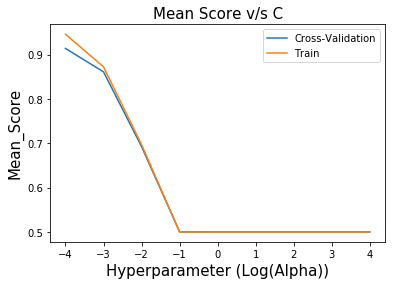

In [21]:
plot_l(gsv)

### Training the model

In [23]:
Best_Param=gsv.best_params_
C=Best_Param['alpha']
Penalty = Best_Param['penalty']

Model_Bow=SGDClassifier(alpha=C,penalty=Penalty,loss='hinge',shuffle=False,class_weight="balanced")
Model_Bow.fit(X_train_bow,Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=False, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


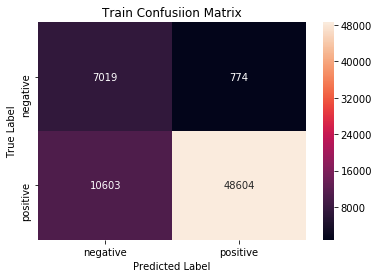

In [24]:
trainconfusionmatrix(Model_Bow,X_train_bow,Y_train)

Confusion Matrix for Test set


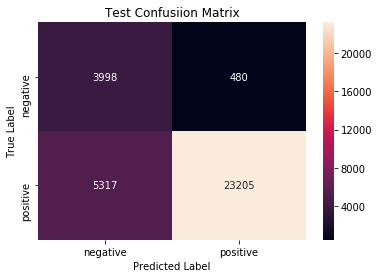

In [25]:
testconfusionmatrix(Model_Bow,X_test_bow,Y_test)

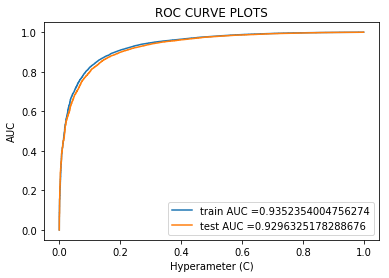

In [26]:
plot_auc_roc_L(Model_Bow,X_train_bow,X_test_bow,Y_train,Y_test)

In [27]:
print("Classification Report: \n")
y_pred=Model_Bow.predict(X_test_bow)

print(classification_report(Y_test, y_pred))


Classification Report: 

              precision    recall  f1-score   support

           0       0.43      0.89      0.58      4478
           1       0.98      0.81      0.89     28522

   micro avg       0.82      0.82      0.82     33000
   macro avg       0.70      0.85      0.73     33000
weighted avg       0.91      0.82      0.85     33000



### Displaying 30 most informative features

In [28]:
show_30_informative_feature(vectorizer,Model_Bow)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		6.557	addict                        		-5.486	anchovi
2.		3.099	alway                         		-5.576	aw
3.		5.918	amaz                          		-6.686	bland
4.		4.781	awesom                        		-4.886	brief
5.		3.891	beat                          		-7.289	clamshel
6.		3.725	beauti                        		-5.133	concept
7.		5.042	best                          		-7.386	credit
8.		3.831	burton                        		-5.385	dirt
9.		6.243	delici                        		-6.302	disappoint
10.		4.048	delight                       		-8.115	edit
11.		3.165	easi                          		-8.200	gopher
12.		6.141	excel                         		-6.973	horchata
13.		4.659	fantast                       		-10.263	horribl
14.		3.686	fast                          		-4.066	lack
15.		3.750	favorit      

## Part 2 : Taking L2 as a Regularisation Parameter

### Finding the best value Of hyperparameter (Alpha)

In [22]:
gsv=Grid_SearchCV(X_train_bow,Y_train,'l2')

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy: 92.20%


### Plot

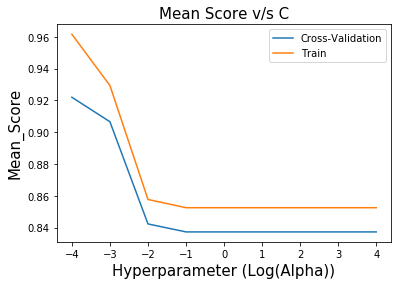

In [23]:
plot_l(gsv)

### Training the model

In [31]:
Best_Param=gsv.best_params_
C=Best_Param['alpha']
Penalty = Best_Param['penalty']

Model_Bow=SGDClassifier(alpha=C,penalty=Penalty,loss='hinge',shuffle=False,class_weight='balanced')
Model_Bow.fit(X_train_bow,Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=False, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


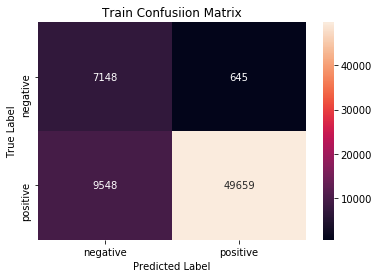

In [32]:
trainconfusionmatrix(Model_Bow,X_train_bow,Y_train)

Confusion Matrix for Test set


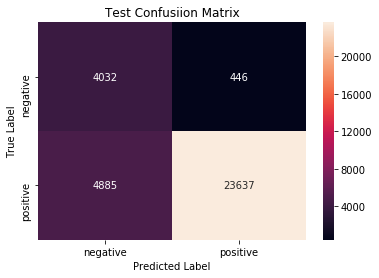

In [33]:
testconfusionmatrix(Model_Bow,X_test_bow,Y_test)

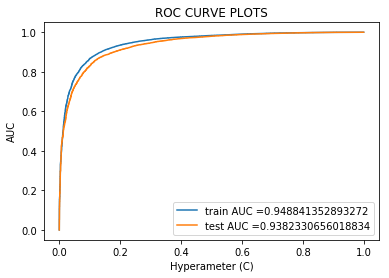

In [34]:
plot_auc_roc_L(Model_Bow,X_train_bow,X_test_bow,Y_train,Y_test)

In [35]:
print("Classification Report: \n")
y_pred=Model_Bow.predict(X_test_bow)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.45      0.90      0.60      4478
           1       0.98      0.83      0.90     28522

   micro avg       0.84      0.84      0.84     33000
   macro avg       0.72      0.86      0.75     33000
weighted avg       0.91      0.84      0.86     33000



### Displaying 30 most informative features

In [36]:
show_30_informative_feature(vectorizer,Model_Bow)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		2.893	addict                        		-2.919	aw
2.		2.360	alway                         		-2.134	away
3.		3.197	amaz                          		-2.315	bad
4.		2.507	awesom                        		-3.416	bland
5.		1.977	beat                          		-2.024	didnt
6.		4.094	best                          		-4.536	disappoint
7.		4.449	delici                        		-1.933	disgust
8.		2.361	easi                          		-2.119	guess
9.		4.225	excel                         		-2.056	hope
10.		2.416	fantast                       		-2.413	horribl
11.		2.080	fast                          		-1.976	howev
12.		2.728	favorit                       		-2.306	lack
13.		2.383	glad                          		-2.317	mayb
14.		2.028	good                          		-2.377	money
15.		4.143	great                      

## TF-IDF Vectorizer

In [24]:
vectorizer_tfidf=TfidfVectorizer()
vectorizer_tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [25]:
X_Train_Tfidf=vectorizer_tfidf.transform(X_train)
X_Train_Tfidf=preprocessing.normalize(X_Train_Tfidf)

X_Test_Tfidf=vectorizer_tfidf.transform(X_test)
X_Test_Tfidf=preprocessing.normalize(X_Test_Tfidf)

In [26]:
print("Shape of Train and Test Data After vectorizations")
print(X_Train_Tfidf.shape, Y_train.shape)
print(X_Test_Tfidf.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(67000, 30737) (67000,)
(33000, 30737) (33000,)


## Taking L1 as a Regularisation Parameter

### Finding the best value Of hyperparameter (Alpha ) 

In [27]:
gsv=Grid_SearchCV(X_Train_Tfidf,Y_train,'l1')

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l1'}
Best Accuracy: 91.45%


### Plot

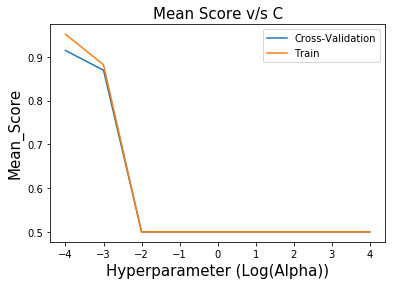

In [28]:
plot_l(gsv)

### Training the model

In [21]:
Best_Param=gsv.best_params_
C=Best_Param['alpha']
Penalty = Best_Param['penalty']

Model_Tfidf=SGDClassifier(alpha=C,penalty=Penalty,loss='hinge',shuffle=False,class_weight='balanced')
Model_Tfidf.fit(X_Train_Tfidf,Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=False, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


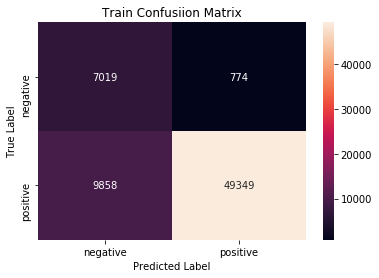

In [22]:
trainconfusionmatrix(Model_Tfidf,X_Train_Tfidf,Y_train)

Confusion Matrix for Test set


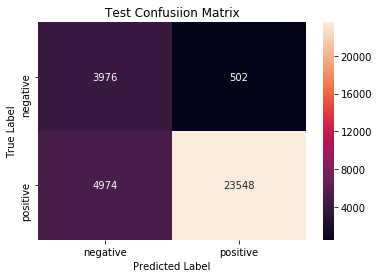

In [23]:
testconfusionmatrix(Model_Tfidf,X_Test_Tfidf,Y_test)

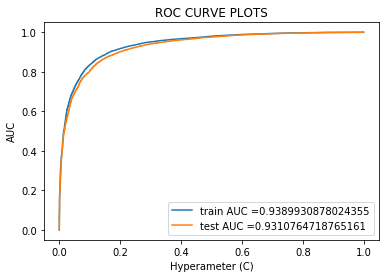

In [24]:
plot_auc_roc_L(Model_Tfidf,X_Train_Tfidf,X_Test_Tfidf,Y_train,Y_test)

In [25]:
print("Classification Report: \n")
y_pred=Model_Tfidf.predict(X_Test_Tfidf)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.44      0.89      0.59      4478
           1       0.98      0.83      0.90     28522

   micro avg       0.83      0.83      0.83     33000
   macro avg       0.71      0.86      0.74     33000
weighted avg       0.91      0.83      0.85     33000



### Displaying 30 most informative features

In [28]:
show_30_informative_feature(vectorizer_tfidf,Model_Tfidf)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		6.218	addict                        		-5.533	alvin
2.		3.493	alway                         		-5.740	billi
3.		6.243	amaz                          		-5.652	bland
4.		4.914	awesom                        		-8.018	brief
5.		3.631	beauti                        		-12.165	categor
6.		8.510	best                          		-7.380	cinematographi
7.		5.288	burton                        		-15.401	clamshel
8.		8.874	delici                        		-8.837	credit
9.		4.007	delight                       		-6.060	debbi
10.		7.494	excel                         		-6.335	deficit
11.		4.363	fantast                       		-7.808	dirt
12.		5.369	favorit                       		-6.838	disappoint
13.		3.787	find                          		-7.074	edit
14.		4.131	glad                          		-8.417	gazillion
15.		4.704	g

## Taking L2 as a Regularisation Parameter

### Finding the best value Of hyperparameter (Alpha )

In [29]:
gsv=Grid_SearchCV(X_Train_Tfidf,Y_train,'l2')

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy: 92.57%


### Plot

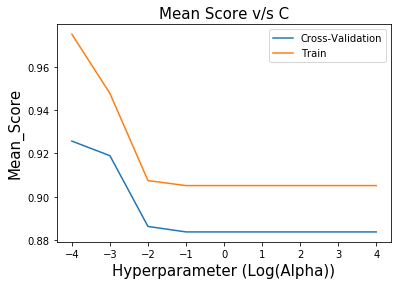

In [30]:
plot_l(gsv)

### Training the mode

In [48]:
Best_Param=gsv.best_params_
C=Best_Param['alpha']
Penalty = Best_Param['penalty']

Model_Tfidf=SGDClassifier(alpha=C,penalty=Penalty,loss='hinge',shuffle=False,class_weight='balanced')
Model_Tfidf.fit(X_Train_Tfidf,Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=False, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


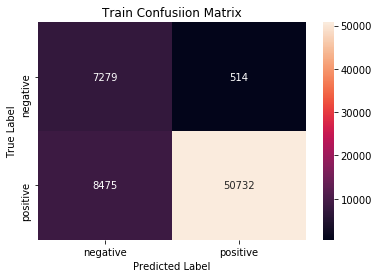

In [49]:
trainconfusionmatrix(Model_Tfidf,X_Train_Tfidf,Y_train)

Confusion Matrix for Test set


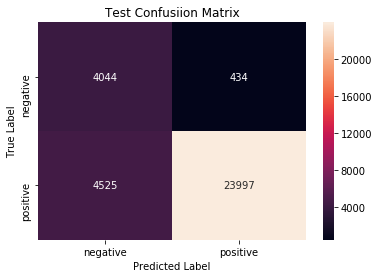

In [50]:
testconfusionmatrix(Model_Tfidf,X_Test_Tfidf,Y_test)

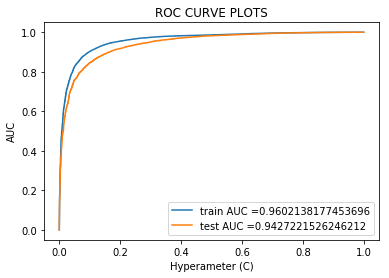

In [51]:
plot_auc_roc_L(Model_Tfidf,X_Train_Tfidf,X_Test_Tfidf,Y_train,Y_test)

In [52]:
print("Classification Report: \n")
y_pred=Model_Tfidf.predict(X_Test_Tfidf)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.47      0.90      0.62      4478
           1       0.98      0.84      0.91     28522

   micro avg       0.85      0.85      0.85     33000
   macro avg       0.73      0.87      0.76     33000
weighted avg       0.91      0.85      0.87     33000



### Displaying 30 most informative features

In [53]:
show_30_informative_feature(vectorizer_tfidf,Model_Tfidf)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		2.749	addict                        		-2.662	aw
2.		2.614	alway                         		-1.930	away
3.		2.992	amaz                          		-2.193	bad
4.		2.450	awesom                        		-3.264	bland
5.		2.087	beat                          		-2.160	didnt
6.		5.369	best                          		-4.585	disappoint
7.		4.792	delici                        		-1.957	disgust
8.		2.346	easi                          		-2.081	gross
9.		4.339	excel                         		-2.012	guess
10.		2.252	fantast                       		-2.115	hope
11.		2.046	fast                          		-2.416	horribl
12.		3.172	favorit                       		-2.484	lack
13.		2.483	find                          		-2.234	mayb
14.		2.164	glad                          		-2.366	money
15.		3.430	good                       

## Word To Vector

In [31]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [32]:
model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)

## Average Word To Vector

In [33]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [34]:
import numpy as np

Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)    

In [35]:
print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (33000, 50)


In [36]:
X_Train_Awv=Train_vectors
X_Test_Awv=Test_vectors

In [37]:
print(X_Train_Awv.shape, Y_train.shape)
print(X_Test_Awv.shape, Y_test.shape)

(67000, 50) (67000,)
(33000, 50) (33000,)


## Taking L1 as a Regularisation Parameter

### Finding the best value Of hyperparameter (Alpha) 

In [38]:
gsv=Grid_SearchCV(X_Train_Awv,Y_train,"l1")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'alpha': 0.001, 'penalty': 'l1'}
Best Accuracy: 88.50%


### Plot

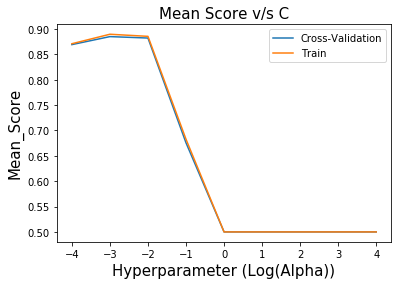

In [39]:
plot_l(gsv)

### Training Model 

In [62]:
Best_Param=gsv.best_params_
C=Best_Param['alpha']
Penalty = Best_Param['penalty']

Model_Awv=SGDClassifier(alpha=C,penalty=Penalty,loss='hinge',shuffle=False,class_weight='balanced')
Model_Awv.fit(X_Train_Awv,Y_train)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=False, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


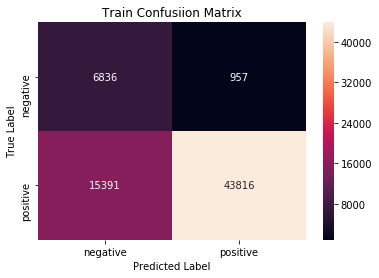

In [63]:
trainconfusionmatrix(Model_Awv,X_Train_Awv,Y_train)

Confusion Matrix for Train set


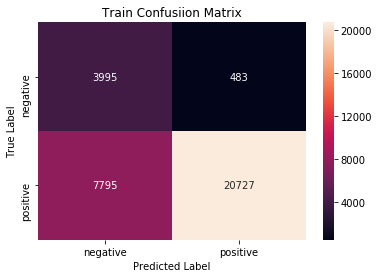

In [64]:
trainconfusionmatrix(Model_Awv,X_Test_Awv,Y_test)

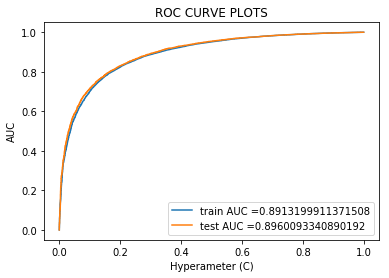

In [65]:
plot_auc_roc_L(Model_Awv,X_Train_Awv,X_Test_Awv,Y_train,Y_test)

In [66]:
print("Classification Report: \n")
y_pred=Model_Awv.predict(X_Test_Awv)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.34      0.89      0.49      4478
           1       0.98      0.73      0.83     28522

   micro avg       0.75      0.75      0.75     33000
   macro avg       0.66      0.81      0.66     33000
weighted avg       0.89      0.75      0.79     33000



## Taking L2 as a Regularisation Parameter

### Finding the best value Of hyperparameter (Alpha)

In [40]:
gsv=Grid_SearchCV(X_Train_Awv,Y_train,"l2")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'alpha': 0.01, 'penalty': 'l2'}
Best Accuracy: 88.90%


### Plot

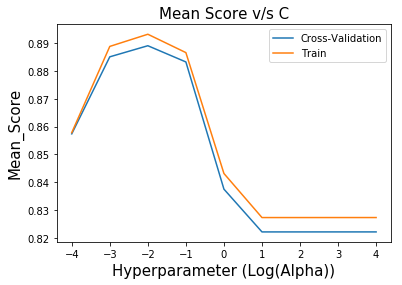

In [41]:
plot_l(gsv)

### Training the model

In [68]:
Best_Param=gsv.best_params_
C=Best_Param['alpha']
Penalty = Best_Param['penalty']

Model_Awv=SGDClassifier(alpha=C,penalty=Penalty,loss='hinge',shuffle=False,class_weight='balanced')
Model_Awv.fit(X_Train_Awv,Y_train)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=False, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


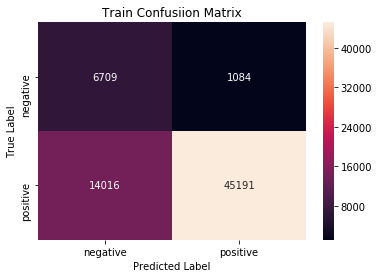

In [69]:
trainconfusionmatrix(Model_Awv,X_Train_Awv,Y_train)

Confusion Matrix for Test set


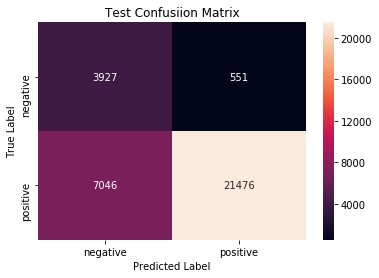

In [70]:
testconfusionmatrix(Model_Awv,X_Test_Awv,Y_test)

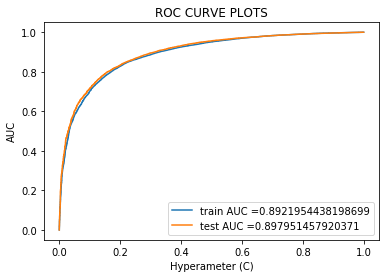

In [71]:
plot_auc_roc_L(Model_Awv,X_Train_Awv,X_Test_Awv,Y_train,Y_test)

In [72]:
print("Classification Report: \n")
y_pred=Model_Awv.predict(X_Test_Awv)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.36      0.88      0.51      4478
           1       0.97      0.75      0.85     28522

   micro avg       0.77      0.77      0.77     33000
   macro avg       0.67      0.81      0.68     33000
weighted avg       0.89      0.77      0.80     33000



## TF-IDF Word To Vector

In [42]:
TFIDF_Feature=vectorizer_tfidf.get_feature_names()
print(len(TFIDF_Feature))
print(TFIDF_Feature[0:20])

30737
['aaa', 'aaaaaaaaagghh', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaah', 'aaah', 'aachen', 'aad', 'aadp', 'aafco', 'aagh', 'aah', 'aahh', 'aand', 'aardvark', 'ab', 'aback', 'abandon', 'abaolut', 'abattoir']


In [43]:
from tqdm import tqdm
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Train_sent):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=model.wv[word]
            tfidf_vec=X_Train_Tfidf[row,TFIDF_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec) 
    row+=1

100%|████████████████████████████████████| 67000/67000 [32:16<00:00, 34.60it/s]


In [44]:
Test_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Test_sent):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=model.wv[word]
            tfidf_vec=X_Test_Tfidf(row,TFIDF_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

100%|████████████████████████████████████| 33000/33000 [11:02<00:00, 49.84it/s]


In [45]:
Train_TFIDF_W2V_Vectors = np.nan_to_num(Train_TFIDF_W2V_Vectors)
Test_TFIDF_W2V_Vectors = np.nan_to_num(Test_TFIDF_W2V_Vectors)

In [46]:
X_Train_TfidfW2v=Train_TFIDF_W2V_Vectors
X_Test_TfidfW2v=Test_TFIDF_W2V_Vectors

In [47]:
print(X_Train_TfidfW2v.shape, Y_train.shape)
print(X_Test_TfidfW2v.shape, Y_test.shape)

(67000, 50) (67000,)
(33000, 50) (33000,)


## Taking L1 as a Regularisation Parameter

### Finding the best value Of hyperparameter (Alpha) 

In [48]:
gsv=Grid_SearchCV(X_Train_TfidfW2v,Y_train,"l1")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'alpha': 0.01, 'penalty': 'l1'}
Best Accuracy: 85.66%


### Plot

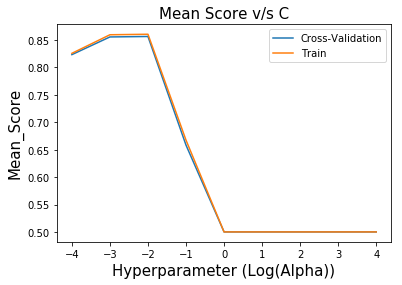

In [49]:
plot_l(gsv)

### Training Model

In [47]:
Best_Param=gsv.best_params_
C=Best_Param['alpha']
Penalty = Best_Param['penalty']

Model_TfidfW2v=SGDClassifier(alpha=C,penalty=Penalty,loss='hinge',shuffle=False,class_weight='balanced')
Model_TfidfW2v.fit(X_Train_TfidfW2v,Y_train)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=False, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


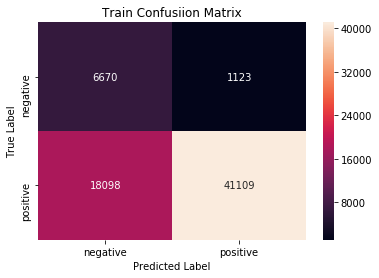

In [48]:
trainconfusionmatrix(Model_TfidfW2v,X_Train_TfidfW2v,Y_train)

Confusion Matrix for Test set


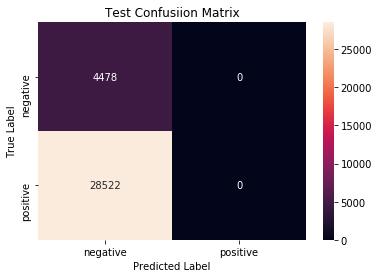

In [49]:
testconfusionmatrix(Model_TfidfW2v,X_Test_TfidfW2v,Y_test)

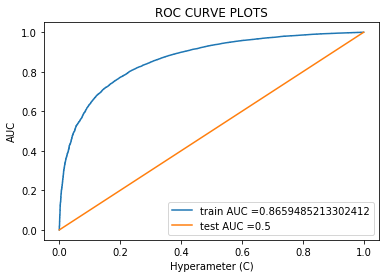

In [86]:
plot_auc_roc_L(Model_TfidfW2v,X_Train_TfidfW2v,X_Test_TfidfW2v,Y_train,Y_test)

In [87]:
print("Classification Report: \n")
y_pred=Model_TfidfW2v.predict(X_Test_TfidfW2v)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.14      1.00      0.24      4478
           1       0.00      0.00      0.00     28522

   micro avg       0.14      0.14      0.14     33000
   macro avg       0.07      0.50      0.12     33000
weighted avg       0.02      0.14      0.03     33000



## Taking L2 as a Regularisation Parameter

### Finding the best value Of hyperparameter (Alpha)

In [50]:
gsv=Grid_SearchCV(X_Train_TfidfW2v,Y_train,"l1")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'alpha': 0.01, 'penalty': 'l1'}
Best Accuracy: 85.66%


### Plot

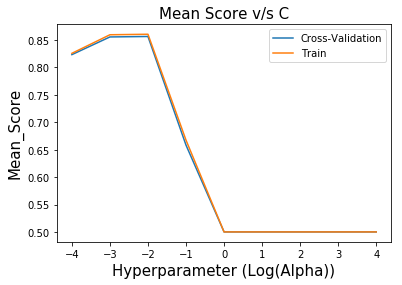

In [51]:
plot_l(gsv)

### Training the model

In [89]:
Best_Param=gsv.best_params_
C=Best_Param['alpha']
Penalty = Best_Param['penalty']

Model_TfidfW2v=SGDClassifier(alpha=C,penalty=Penalty,loss='hinge',shuffle=False,class_weight='balanced')
Model_TfidfW2v.fit(X_Train_TfidfW2v,Y_train)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=False, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


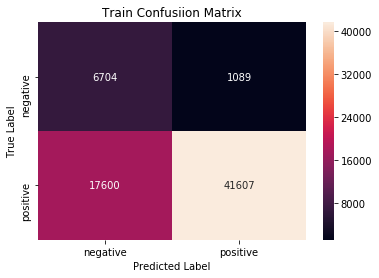

In [90]:
trainconfusionmatrix(Model_TfidfW2v,X_Train_TfidfW2v,Y_train)

Confusion Matrix for Test set


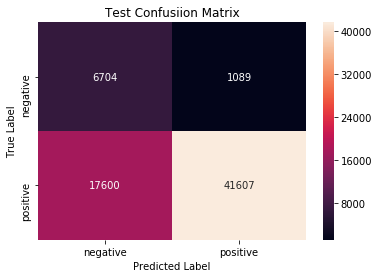

In [91]:
testconfusionmatrix(Model_TfidfW2v,X_Test_TfidfW2v,Y_train)

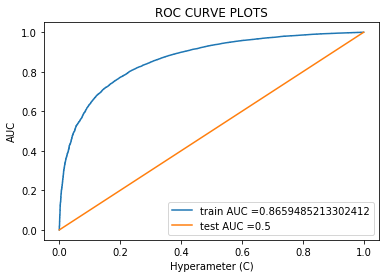

In [92]:
plot_auc_roc_L(Model_TfidfW2v,X_Train_TfidfW2v,X_Test_TfidfW2v,Y_train,Y_test)

In [93]:
print("Classification Report: \n")
y_pred=Model_TfidfW2v.predict(X_Test_TfidfW2v)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.14      1.00      0.24      4478
           1       0.00      0.00      0.00     28522

   micro avg       0.14      0.14      0.14     33000
   macro avg       0.07      0.50      0.12     33000
weighted avg       0.02      0.14      0.03     33000



# Using RBF Kernal

In [52]:
Data_RBF = Data.head(20000)

In [53]:
Y = Data_RBF['Score']
X = Data_RBF['CleanedText']

In [54]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is random splitting

print("Shape of Train and Test Dataset for 100k points")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

Shape of Train and Test Dataset for 100k points
(13400,) (13400,)
(6600,) (6600,)


## Bag Of Words

In [55]:
vectorizer = CountVectorizer(max_features=500)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_train_bow=preprocessing.normalize(X_train_bow)

X_test_bow = vectorizer.transform(X_test)
X_test_bow=preprocessing.normalize(X_test_bow)

print("Shape of Train and Test Data After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_test_bow.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(13400, 500) (13400,)
(6600, 500) (6600,)


### Finding the best value of hyperparameter Alpha

In [56]:
gsv=Grid_SearchCV_RBF(X_train_bow,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  9.2min finished


Best HyperParameter:  {'C': 100}
Best Accuracy: 87.13%


### Plot

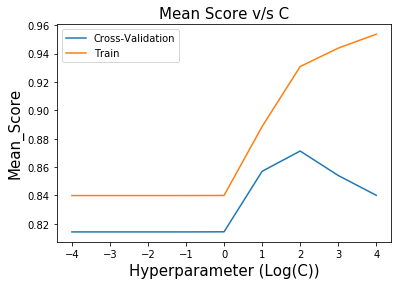

In [57]:
plot_r(gsv)

### Training the model

In [100]:
Best_Param=gsv.best_params_
C = Best_Param['C']

Model_Bow=SVC(C=C,probability=True,class_weight='balanced')
Model_Bow.fit(X_train_bow,Y_train)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Evaluating the performance of model

Confusion Matrix for Train set


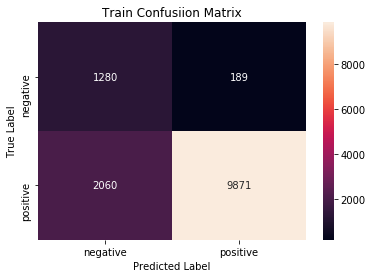

In [101]:
trainconfusionmatrix(Model_Bow,X_train_bow,Y_train)

Confusion Matrix for Test set


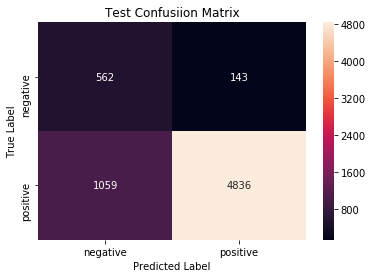

In [102]:
testconfusionmatrix(Model_Bow,X_test_bow,Y_test)

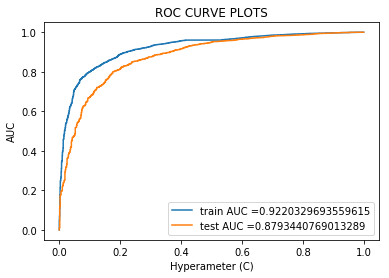

In [103]:
plot_auc_roc(Model_Bow,X_train_bow,X_test_bow,Y_train,Y_test)

In [104]:
print("Classification Report: \n")
y_pred=Model_Bow.predict(X_test_bow)

print(classification_report(Y_test, y_pred))


Classification Report: 

              precision    recall  f1-score   support

           0       0.35      0.80      0.48       705
           1       0.97      0.82      0.89      5895

   micro avg       0.82      0.82      0.82      6600
   macro avg       0.66      0.81      0.69      6600
weighted avg       0.90      0.82      0.85      6600



### TF-IDF Vectorizer

In [58]:
vectorizer_tfidf=TfidfVectorizer()
vectorizer_tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [59]:
X_Train_Tfidf=vectorizer_tfidf.transform(X_train)
X_Train_Tfidf=preprocessing.normalize(X_Train_Tfidf)

X_Test_Tfidf=vectorizer_tfidf.transform(X_test)
X_Test_Tfidf=preprocessing.normalize(X_Test_Tfidf)

In [60]:
print("Shape of Train and Test Data After vectorizations")
print(X_Train_Tfidf.shape, Y_train.shape)
print(X_Test_Tfidf.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(13400, 15698) (13400,)
(6600, 15698) (6600,)


### Finding the best value of hyperparameter Alpha

In [61]:
gsv=Grid_SearchCV_RBF(X_Train_Tfidf,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 14.2min finished


Best HyperParameter:  {'C': 1000}
Best Accuracy: 90.33%


### Plot

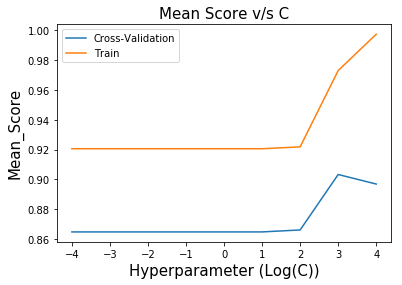

In [62]:
plot_r(gsv)

### Training the model

In [109]:
Best_Param=gsv.best_params_
C = Best_Param['C']

Model_Tfidf=SVC(C=C,probability=True,class_weight='balanced')
Model_Tfidf.fit(X_Train_Tfidf,Y_train)

SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Evaluating the performance of model

Confusion Matrix for Train set


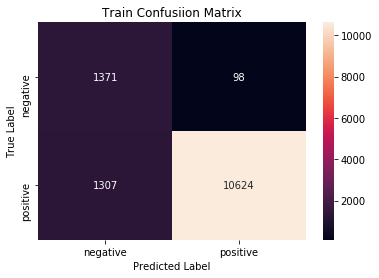

In [112]:
trainconfusionmatrix(Model_Tfidf,X_Train_Tfidf,Y_train)

Confusion Matrix for Test set


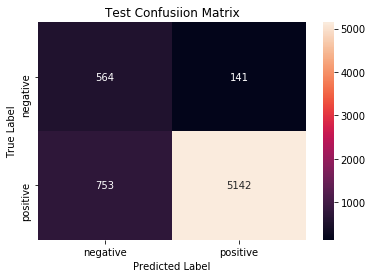

In [113]:
testconfusionmatrix(Model_Tfidf,X_Test_Tfidf,Y_test)

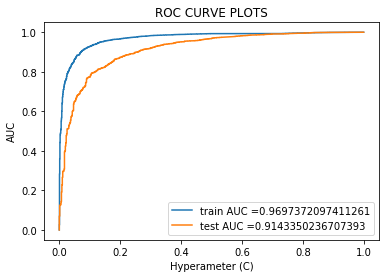

In [114]:
plot_auc_roc(Model_Tfidf,X_Train_Tfidf,X_Test_Tfidf,Y_train,Y_test)

In [115]:
print("Classification Report: \n")
y_pred=Model_Tfidf.predict(X_Test_Tfidf)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.43      0.80      0.56       705
           1       0.97      0.87      0.92      5895

   micro avg       0.86      0.86      0.86      6600
   macro avg       0.70      0.84      0.74      6600
weighted avg       0.92      0.86      0.88      6600



### Word To Vector 

In [63]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [64]:
model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)

In [65]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [66]:
import numpy as np

Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)    

In [67]:
print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (6600, 50)


In [68]:
X_Train_Awv=Train_vectors
X_Test_Awv=Test_vectors

In [69]:
print(X_Train_Awv.shape, Y_train.shape)
print(X_Test_Awv.shape, Y_test.shape)

(13400, 50) (13400,)
(6600, 50) (6600,)


### Finding the best hyperparameter (C)

In [70]:
gsv=Grid_SearchCV_RBF(X_Train_Awv,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.5min finished


Best HyperParameter:  {'C': 10}
Best Accuracy: 86.11%


### Plot

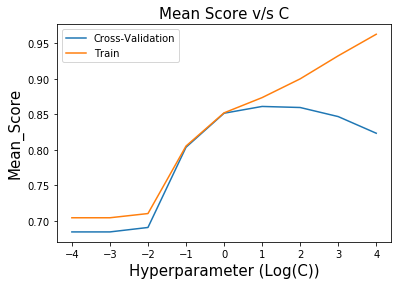

In [71]:
plot_r(gsv)

### Training the model

In [124]:
Best_Param=gsv.best_params_
C = Best_Param['C']

Model_Awv=SVC(C=C,probability=True,class_weight='balanced')
Model_Awv.fit(X_Train_Awv,Y_train)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Evaluating the performance of model


Confusion Matrix for Train set


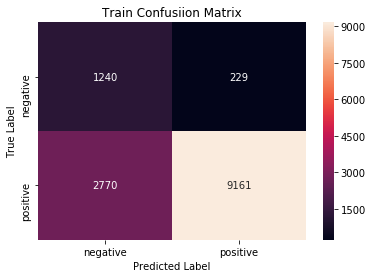

In [125]:
trainconfusionmatrix(Model_Awv,X_Train_Awv,Y_train)

Confusion Matrix for Test set


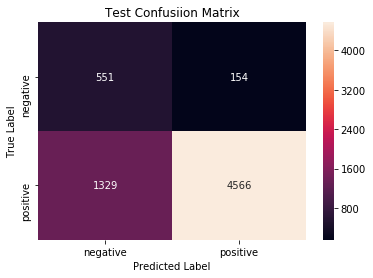

In [126]:
testconfusionmatrix(Model_Awv,X_Test_Awv,Y_test)

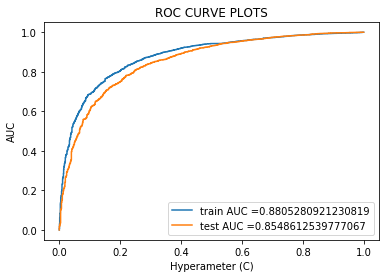

In [127]:
plot_auc_roc(Model_Awv,X_Train_Awv,X_Test_Awv,Y_train,Y_test)

In [128]:
print("Classification Report: \n")
y_pred=Model_Awv.predict(X_Test_Awv)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.29      0.78      0.43       705
           1       0.97      0.77      0.86      5895

   micro avg       0.78      0.78      0.78      6600
   macro avg       0.63      0.78      0.64      6600
weighted avg       0.90      0.78      0.81      6600



### Tf-IDF Word To Vector

In [72]:
TFIDF_Feature=vectorizer_tfidf.get_feature_names()
print(len(TFIDF_Feature))
print(TFIDF_Feature[0:20])

15698
['aaaaah', 'aafco', 'aagh', 'aah', 'ab', 'aback', 'abandon', 'abba', 'abc', 'abdomen', 'abdomin', 'abhor', 'abid', 'abil', 'abj', 'abl', 'abliti', 'abnorm', 'aboard', 'abod']


In [73]:
from tqdm import tqdm
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Train_sent):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=model.wv[word]
            tfidf_vec=X_Train_Tfidf[row,TFIDF_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec) 
    row+=1

100%|████████████████████████████████████| 13400/13400 [02:49<00:00, 79.23it/s]


In [74]:
Test_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Test_sent):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=model.wv[word]
            tfidf_vec=X_Test_Tfidf(row,TFIDF_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

100%|█████████████████████████████████████| 6600/6600 [00:56<00:00, 117.44it/s]


In [75]:
Train_TFIDF_W2V_Vectors = np.nan_to_num(Train_TFIDF_W2V_Vectors)
Test_TFIDF_W2V_Vectors = np.nan_to_num(Test_TFIDF_W2V_Vectors)

In [76]:
X_Train_TfidfW2v=Train_TFIDF_W2V_Vectors
X_Test_TfidfW2v=Test_TFIDF_W2V_Vectors

In [77]:
print(X_Train_TfidfW2v.shape, Y_train.shape)
print(X_Test_TfidfW2v.shape, Y_test.shape)

(13400, 50) (13400,)
(6600, 50) (6600,)


### Finding the best hyperparameter (C)

In [78]:
gsv=Grid_SearchCV_RBF(X_Train_TfidfW2v,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.8min finished


Best HyperParameter:  {'C': 10}
Best Accuracy: 83.63%


### Plot

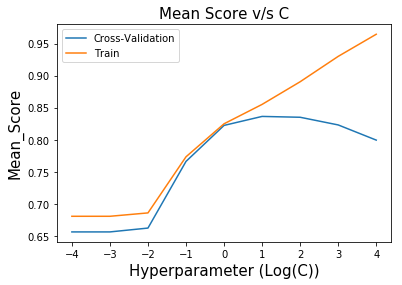

In [79]:
plot_r(gsv)

### Training the model

In [136]:
Best_Param=gsv.best_params_
C = Best_Param['C']

Model_TfidfW2v=SVC(C=C,probability=True,class_weight='balanced')
Model_TfidfW2v.fit(X_Train_TfidfW2v,Y_train)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Evaluating the performance of model

Confusion Matrix for Train set


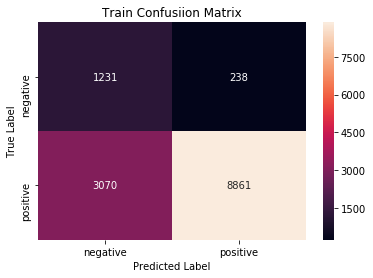

In [137]:
trainconfusionmatrix(Model_TfidfW2v,X_Train_TfidfW2v,Y_train)

In [ ]:
testconfusionmatrix(Model_TfidfW2v,X_Test_TfidfW2v,Y_test)

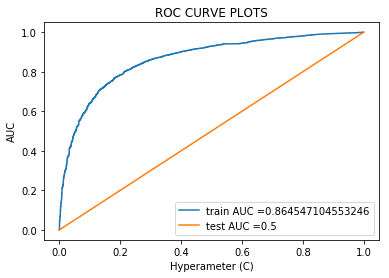

In [139]:
plot_auc_roc(Model_TfidfW2v,X_Train_TfidfW2v,X_Test_TfidfW2v,Y_train,Y_test)

In [140]:
print("Classification Report: \n")
y_pred=Model_TfidfW2v.predict(X_Test_TfidfW2v)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.11      1.00      0.19       705
           1       0.00      0.00      0.00      5895

   micro avg       0.11      0.11      0.11      6600
   macro avg       0.05      0.50      0.10      6600
weighted avg       0.01      0.11      0.02      6600



#### 1.Report On Different Vectorizer Method and RBF Kernel

In [75]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter(C)","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",100,0.90,0.87,0.86])
x.add_row(["TF-IDF",1000,0.97,0.91,0.94])
x.add_row(["Avg W2V",100,0.88,0.84,0.85])
x.add_row(["TF-IDF W2V",1000,0.90,0.50,0.84])

print(x)

+------------+-------------------+-----------+----------+----------+
| Vectorizer | Hyperparameter(C) | Train AUC | Test AUC | F1-Score |
+------------+-------------------+-----------+----------+----------+
|    BOW     |        100        |    0.9    |   0.87   |   0.86   |
|   TF-IDF   |        1000       |    0.97   |   0.91   |   0.94   |
|  Avg W2V   |        100        |    0.88   |   0.84   |   0.85   |
| TF-IDF W2V |        1000       |    0.9    |   0.5    |   0.84   |
+------------+-------------------+-----------+----------+----------+


#### 2.Report On Different Vectorizer Method and Linear Kernel (L1 Regularisation Parameter)

In [50]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter(Alpha)","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",0.0001,0.93,0.92,0.87])
x.add_row(["TF-IDF",0.0001,0.93,0.93,0.87])
x.add_row(["Avg W2V",0.001,0.89,0.89,0.83])
x.add_row(["TF-IDF W2V",0.001,0.86,0.50,0.80])

print(x)

+------------+-----------------------+-----------+----------+----------+
| Vectorizer | Hyperparameter(Alpha) | Train AUC | Test AUC | F1-Score |
+------------+-----------------------+-----------+----------+----------+
|    BOW     |         0.0001        |    0.93   |   0.92   |   0.87   |
|   TF-IDF   |         0.0001        |    0.93   |   0.93   |   0.87   |
|  Avg W2V   |         0.001         |    0.89   |   0.89   |   0.83   |
| TF-IDF W2V |         0.001         |    0.86   |   0.5    |   0.8    |
+------------+-----------------------+-----------+----------+----------+


#### 3.Report On Different Vectorizer Method and Linear Kernel (L2 Regularisation Parameter)

In [51]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter(Alpha)","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",0.0001,0.94,0.93,0.88])
x.add_row(["TF-IDF",0.0001,0.96,0.94,0.88])
x.add_row(["Avg W2V",0.001,0.89,0.89,0.80])
x.add_row(["TF-IDF W2V",0.001,0.86,0.50,0.80])

print(x)

+------------+-----------------------+-----------+----------+----------+
| Vectorizer | Hyperparameter(Alpha) | Train AUC | Test AUC | F1-Score |
+------------+-----------------------+-----------+----------+----------+
|    BOW     |         0.0001        |    0.94   |   0.93   |   0.88   |
|   TF-IDF   |         0.0001        |    0.96   |   0.94   |   0.88   |
|  Avg W2V   |         0.001         |    0.89   |   0.89   |   0.8    |
| TF-IDF W2V |         0.001         |    0.86   |   0.5    |   0.8    |
+------------+-----------------------+-----------+----------+----------+


#### 4. I have used SGDClassifier for Linear SVM on 100K DataSet and SVC for RBF SVM on 20K DataSet.
#### 5. Since data is unbalanced , i did time based splitting and used roc_auc metric as scoring parameter in GridsearchCV .
#### 6. In case of RBF SVM , TFIDF is performing better than other.
#### 7. In Case of Linear SVM , TFIDF-W2V is overfitting.